In [ ]:
pip install librosa

In [9]:
import os
import urllib.request

# URL to download the script from
branch = 'main'  # or whichever branch you want to use
url = f'https://raw.githubusercontent.com/NVIDIA/NeMo/{branch}/scripts/dataset_processing/process_speech_commands_data.py'
file_path = 'process_speech_commands_data.py'

# Check if the file already exists
if not os.path.exists(file_path):
    print(f"{file_path} not found. Downloading from {url}...")
    
    # Use urllib to download the file
    urllib.request.urlretrieve(url, file_path)
    
    print(f"{file_path} downloaded successfully!")
else:
    print(f"{file_path} already exists.")

process_speech_commands_data.py already exists.


python process_speech_commands_data.py --data_root C:\Users\naikg\keyword-spotting\data --data_version 2 --class_split  all --num_processes 4 --rebalance --log

In [10]:
# Read file paths and labels from the text file
def read_file_paths_and_labels(file_list_path):
    file_paths = []
    labels = []
    with open(file_list_path, 'r') as file:
        for line in file:
            
            
            line = line.strip() 
            # Remove any leading/trailing whitespace
            if line:
                label, filename = line.split('/', 1)
                
                full_path = os.path.join("C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2", line)
                
                file_paths.append(full_path)
                labels.append(label)
    return file_paths, labels

# Example file list path
file_list_path = 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\testing_list.txt'
file_paths, labels = read_file_paths_and_labels(file_list_path)

# Load and process all audio files
audio_data = {}

In [11]:
import numpy as np
import librosa
import os


def load_audio(file_path, sr=16000):
    # Load the audio file with librosa
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio, sample_rate

def load_all_audios_from_directory(directory, sr=16000):
    audio_data = {}

In [12]:


def normalize_audio(audio):
    return librosa.util.normalize(audio)

def normalize_all_audios(audio_data):
    normalized_audio_data = {}
    
    for file_name, (audio, sample_rate) in audio_data.items():
        normalized_audio = normalize_audio(audio)
        normalized_audio_data[file_name] = (normalized_audio, sample_rate)
    
    return normalized_audio_data



# Now 'normalized_audio_files' contains a dictionary with file names as keys and (normalized_audio, sample_rate) as values


In [13]:
def extract_mel_spectrogram(audio, sr, n_mels=40, hop_length=512, n_fft=2048):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to log scale (dB)
    return mel_spec_db

def extract_mel_spectrograms(audio_data, n_mels=40, hop_length=512, n_fft=2048):
    mel_spectrograms = {}
    
    for file_name, (audio, sr) in audio_data.items():
        mel_spec = extract_mel_spectrogram(audio, sr, n_mels, hop_length, n_fft)
        mel_spectrograms[file_name] = mel_spec
    
    return mel_spectrograms

In [14]:
def extract_mfcc(audio, sr, n_mfcc=13, hop_length=512, n_fft=2048):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return mfcc

def extract_mfcc_features(audio_data, **kwargs):
    features = {}
    
    for file_name, (audio, sr) in audio_data.items():
        feature = extract_mfcc(audio, sr, **kwargs)
        features[file_name] = feature
        
        # Plotting the MFCC features
        plt.figure(figsize=(10, 4))
        plt.imshow(feature, aspect='auto', origin='lower', cmap='jet')
        plt.title(f'MFCC Features of {file_name}')
        plt.xlabel('Frame Index')
        plt.ylabel('MFCC Coefficient Index')
        plt.colorbar(label='MFCC Coefficient Value')
        plt.tight_layout()
        plt.show()
    
    return features

In [15]:
import numpy as np


def pad_or_trim_audio(audio, max_length, sr):
    """
    Pads or trims the audio to ensure it has a fixed length.

    Args:
        audio (numpy array): The audio data.
        max_length (float): Desired length of the audio in seconds.
        sr (int): Sample rate of the audio.

    Returns:
        numpy array: Audio data padded or trimmed to the desired length.
    """
    # Calculate the target length in samples
    target_length = int(max_length * sr)

    # Trim if longer than target length
    if len(audio) > target_length:
        return audio[:target_length]
    # Pad with zeros if shorter than target length
    else:
        return np.pad(audio, (0, target_length - len(audio)))


def pad_or_trim_audios(normalized_audio_files):
    audio_fixed_length = {}
    
    for file_name, (audio, sample_rate) in normalized_audio_files.items():
        audio_length =pad_or_trim_audio(audio, max_length=1.0, sr=sample_rate)
        audio_fixed_length[file_name] =audio_length
    
    return audio_fixed_length


In [16]:
import numpy as np
import librosa
import scipy.signal

def noise_reduction(audio, sr, noise_reduction_factor=0.5, frame_length=2048, hop_length=512):
   
    # Perform Short-Time Fourier Transform (STFT)
    stft = librosa.stft(audio, n_fft=frame_length, hop_length=hop_length)
    magnitude, phase = librosa.magphase(stft)

    # Calculate the mean magnitude of the noise
    noise_mean = np.mean(magnitude, axis=1, keepdims=True)
    
    # Create a mask based on the noise mean and reduction factor
    mask = magnitude > (noise_mean * noise_reduction_factor)
    
    # Apply the mask to the magnitude
    magnitude_cleaned = magnitude * mask
    
    # Reconstruct the complex STFT
    stft_cleaned = magnitude_cleaned * phase

    # Perform Inverse Short-Time Fourier Transform (ISTFT)
    cleaned_audio = librosa.istft(stft_cleaned, hop_length=hop_length)

    return cleaned_audio


In [9]:
features_list = []
labels_list = []
for file_path in file_paths:
    print(file_path)
    audio, sr = load_audio(file_path)
    normalized_audio = normalize_audio(audio)
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
    mel_spectrogram_features = extract_mel_spectrogram(normalized_audio,sr)
    mfcc_features =extract_mfcc(normalized_audio,sr, n_mfcc=13, hop_length=512, n_fft=2048)
    features_list.append(mfcc_features)
    labels_list.append(labels[file_paths.index(file_path)])



C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1f653d27_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/6b889021_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8494fba8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/7257420c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/84d1e469_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/adebe223_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c518d1b1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d103dd6e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/964e8cfd_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/af130f12_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/964c7c9e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/3efef882_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/aef8dcf5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e9901cf0_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/84d1e469_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44715c1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44715c1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8625475c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/daf230ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/412c675c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/aa80f517_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spottin

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/3b4f8f24_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spottin

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/1acc97de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/84d1e469_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/adebe223_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/2d82a556_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/e71b4ce6_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fa446c16_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/587f3271_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d2dd5785_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cfde27ba_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/dc75148d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/62ff07ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/cfde27ba_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/412c675c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b1f8326d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b7e9f841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b7e9f841_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/ea356919_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/5525ff66_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/9b3ea809_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a80f9f53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/18f8afd5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bb05582b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/2796ac50_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/aa80f517_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0ea0e2f4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/6b889021_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/022cd682_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/370844f7_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c781f251_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c22d3f18_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0c40e715_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/6205088b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/475b61f1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b97c9f77_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5ff3f9a1_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/553f1a79_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9e2ce5e3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/2796ac50_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/0f250098_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/af8b2f2c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/370844f7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/7add4c5f_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/84d1e469_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af405b69_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af130f12_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5c8af87a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9e2ce5e3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_10.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/2796ac50_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8ec6dab6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d962e5ac_nohash_3.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3b4f8f24_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/0c540988_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1b4c9b89_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/7bae88ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b97c9f77_nohash_4.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f9643d42_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b97c9f77_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cc592808_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a60a09cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5c8af87a_nohash_0.

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/20d3f11f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5744b6a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a9f54d8d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a9f54d8d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/b11a05d2_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a2473d62_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/4c7c95de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/cc592808_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c9e251d2_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/475b61f1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3efef882_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/87070229_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4c6167ca_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d103dd6e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4fd1443e_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/798f702a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/fe1916ba_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b1f8326d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/422d3197_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/422d3197_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b1f8326d_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8c7f81df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4fd1443e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/43fc47a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4845bb10_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4c6167ca_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d962e5ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d962e5ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1fe4c891_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5e3dde6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/964e8cfd_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/412c675c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1b4c9b89_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b83c1acf_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a60a09cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/68dd409e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffb86d3c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffb86d3c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_11.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sto

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/bb31b82b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cc592808_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a7c1f83_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4f8ef132_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9ba34294_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f0ae7203_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8ec6dab6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/43fc47a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ef2a3cfb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/03401e93_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c6167ca_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fe1916ba_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b1f8326d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f297e878_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/62ff07ef_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af130f12_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/62ff07ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/90b94017_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/85834399_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/d7467392_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a1533da4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/85834399_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/7e1054e7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4f8ef132_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f264e0df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/964c7c9e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3efef882_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5ff3f9a1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3efef882_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3b4f8f24_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/863880b7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b4877f8e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3b4f8f24_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/db24628d_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/1acc97de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b1f8326d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/653a48f5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/653a48f5_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b83c1acf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a2473d62_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b97c9f77_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/553f1a79_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/9e2ce5e3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/4290ca61_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5828dfa2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/caedb73a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8a325749_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8a325749_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5828dfa2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/7bae88ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/84d1e469_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e1469561_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/03401e93_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a356ab9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/48a8a69d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/964e8cfd_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/daf230ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/63f7a489_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2aa787cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f3bece8_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0fa1e7a9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9b3ea809_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f9643d42_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b97c9f77_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/cc592808_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9e251d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1f653d27_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bb05582b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9dc1889e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9dc1889e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1f653d27_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/553f1a79_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b11a05d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/863880b7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/422d3197_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/587f3271_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d1a4fb3f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5d7ed425_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/fdb5155e_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37fc5d97_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8ec6dab6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f6af2457_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4290ca61_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/50033893_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2aa787cf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/83957201_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1b4c9b89_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ea356919_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/63f7a489_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f9643d42_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b97c9f77_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4f8ef132_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cc592808_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/0b57a6ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8c0e5970_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/24ad3ebe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/881583a6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/d1bf406b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8625475c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5744b6a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/cc592808_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/4f8ef132_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/b7e9f841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5525ff66_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/840c366d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e71b4ce6_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3cbd76a3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3cbd76a3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/87070229_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5f814c23_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4c6167ca_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4fd1443e_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7192fddc_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/964e8cfd_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/964e8cfd_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7add4c5f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fb7eb481_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/2fa39636_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b83c1acf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5f449e17_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/82b99576_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e5e54cee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b83c1acf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a2473d62_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0bac8a71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/1f653d27_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/ffb86d3c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4620dc14_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/8a325749_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/8a325749_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/aa233654_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/97f4c236_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/563aa4e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/fdb5155e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1fe4c891_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8ec6dab6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/27c30960_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b49caed3_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/26b28ea7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/26b28ea7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0c540988_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1b4c9b89_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cfbedf

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fce96bac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e41a903b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/beb458a4_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/83957201_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5828dfa2_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b83c1acf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e0c782d5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f264e0df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/63f7a489_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f9643d42_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/0bac8a71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a80f9f53_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4fd1443e_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6f2f57c1_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/91b03183_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/798f702a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fe1916ba_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1acc97de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/422d3197_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/893705bb_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/af7a8296_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/6f689791_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8c7f81df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/837a0f64_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/1fe4c891_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/210f3aa9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5f01c798_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/87070229_nohash_3.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8ea6dec6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8ea6dec6_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c7c95de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/81dc4a94_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0cb74144_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5b1db3ee_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aef8dcf5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4290ca61_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1093c8e7_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c841771_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0b57a6ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b49caed3_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7dc95912_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c7c95de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/27e6f0f0_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/03401e93_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/6379c6a2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e5ac_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3efef882_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5ff3f9a1_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/87070229_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4c6167ca_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/b11a05d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/91b03183_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/653a48f5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/422d3197_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fe1916ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/bb31b82b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a2473d62_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/189cbabe_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e1469561_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9ba34294_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/48a8a69d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a1533da4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/893705bb_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/283d7a53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a1533da4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a591c2ea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af8b2f2c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/587f3271_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5e3dde6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb31b82b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f9643d42_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7bae88ed_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9a7c1f83_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

In [11]:
features_list = []
labels_list = []
for file_path in file_paths:
    print(f"Processing file: {file_path}")
    
    # Load and normalize audio
    audio, sr = load_audio(file_path)
    normalized_audio = normalize_audio(audio)
    
    # Apply noise reduction
    denoised_audio = noise_reduction(normalized_audio, sr)
    
    # Pad or trim audio
    padded_audio = pad_or_trim_audio(denoised_audio, max_length=1.0, sr=sr)
    
    # Extract features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)
    mel_spectrogram_features = extract_mel_spectrogram(padded_audio, sr)
    
    # Append features and labels to lists
    features_list.append(mfcc_features)
    labels_list.append(labels[file_paths.index(file_path)])


Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bb05582b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/97f4c236_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f2e59fea_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fdb5155e_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/dc75148d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3f170018_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5c8af87a_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/840c366d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5ff3f9a1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0bac8a71_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3efef882_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/692a88e6_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/6e916de8_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/85834399_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d7467392_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3cbd76a3_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d7467392_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/6e916de8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/87070229_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7e1054e7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5f814c23_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/893705bb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/653a48f5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/587f3271_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/893705bb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b1f8326d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b49caed3_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8ea6dec6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ca4d5368_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/db24628d_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/94de6a6a_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/94de6a6a_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/2aa787cf_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/6736bc64_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b83c1acf_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b737ee80_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ad6a46f1_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f9643d42_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3df9a3d4_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d5b963aa_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f9643d42_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b97c9f77_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/4f8ef132_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cc592808_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/189cbabe_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f292725f_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/475b61f1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0c40e715_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/62ff07ef_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/bb05582b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c518d1b1_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ffb86d3c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/563aa4e6_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9dc1889e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1f653d27_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cfbedff9_nohash_2.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d962e5ac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a8e25ebb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1093c8e7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8ec6dab6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1fe4c891_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_5.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4845bb10_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/42beb5eb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/220ee1ef_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/bed06fac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d9e9f554_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9a69672b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1acc97de_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/3659fc1c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b49caed3_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/91b03183_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/3b4f8f24_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_4.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a6f2fd71_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c22d3f18_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1b4c9b89_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4620dc14_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/83957201_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/0cb74144_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/aa233654_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/94de6a6a_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c22d3f18_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8fe67225_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f292725f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a4e8a997_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1b4c9b89_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4f8ef132_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b97c9f77_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f9643d42_nohash_3.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/aa80f517_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/5ff3f9a1_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/840c366d_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/d056d4d8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/fce96bac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/40c4e774_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/2796ac50_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/fe1916ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ca48dc76_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/bb31b82b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/9d171fee_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/4620dc14_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/a4383927_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/83957201_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/6021f08b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/caedb73a_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/7257420c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/aef8dcf5_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/68dd409e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82d0d3ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f428ca69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af130f12_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af405b69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e9901cf0_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/84d1e469_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8625475c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/0ea0e2f4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/863880b7_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/863880b7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44715c1c_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/1acc97de_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/a9f54d8d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/1f3bece8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82b99576_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e5e54cee_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82b99576_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/1f3bece8_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/bfd26d6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/a2473d62_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/b97c9f77_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/4c7c95de_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/6379c6a2_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_8.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/d962e5ac_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/87070229_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/4c6167ca_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5f01c798_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/03401e93_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/c7dc7278_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backw

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/189cbabe_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a7216980_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a7216980_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/8769c34c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/8fe67225_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/189cbabe_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f9643d42_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/0cb74144_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backw

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/aa80f517_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/d962e5ac_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/87070229_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/4fd1443e_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/4fd1443e_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/27e6f0f0_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/8fe67225_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/63f7a489_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bfd26d6b_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/dfdabe19_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/dfdabe19_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/189cbabe_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a7216980_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/8769c34c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/8fe67225_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fdb5155e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/e9901cf0_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/563aa4e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/97f4c236_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/62ff07ef_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/ffb86d3c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/9dc1889e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/2d82a556_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/e71b4ce6_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fb7eb481_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5170b77f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/db24628d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/370844f7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/8ea6dec6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d1a4fb3f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/b1f8326d_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/893705bb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/653a48f5_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/85d2ac4b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/f264e0df_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/ea356919_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/85d2ac4b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d0faf7e4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/0cb74144_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/a4e8a997_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cc592808_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/6205088b_nohash_3.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/4845bb10_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/37fc5d97_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/42beb5eb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/4c6167ca_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/135c6841_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/a1533da4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/283d7a53_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/a1533da4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/0acc1ac5_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/5eb5fc74_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/83957201_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/a4383927_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/9a7c1f83_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/1b4c9b89_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/f5496439_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/c22d3f18_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/7bae88ed_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b737ee80_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f428ca69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/af130f12_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c518d1b1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bb05582b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/68dd409e_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/62ff07ef_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/97f4c236_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/563aa4e6_nohash_1.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/692a88e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/553f1a79_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5c8af87a_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/893705bb_nohash_10.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d5ca80c6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/2796ac50_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/4fd1443e_nohash_0.wav
Processing file: C:\Users\n

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/7192fddc_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/6b889021_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cd85758f_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/022cd682_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5e3dde6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a69672b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/50033893_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1acc97de_nohash_2.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/893705bb_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fa446c16_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b49caed3_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fe1916ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/798f702a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca48dc76_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/370844f7_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5170b77f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/db24628d_nohash_2.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b83c1acf_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bfd26d6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ea356919_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e0c782d5_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/63f7a489_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d0faf7e4_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a2473d62_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d5b963aa_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0cb74144_nohash_3.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/adebe223_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/f2e59fea_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/18f8afd5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/44260689_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/f0ae7203_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/881583a6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/d91a159e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/44260689_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/adebe223_nohash_1.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/d7467392_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/85834399_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/a591c2ea_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/caf9fceb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/105a0eea_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5744b6a7_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/2c6d3924_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/26b28ea7_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/863880b7_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/6736bc64_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/dfdabe19_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/0fa1e7a9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/6736bc64_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/6021f08b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/b737ee80_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/dcb57584_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/3df9a3d4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/a7216980_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af405b69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f2e59fea_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/84d1e469_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8fe52b97_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/18f8afd5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5b1db3ee_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e1469561_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5c8af87a_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/692a88e6_nohash_4.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5c8af87a_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9e2ce5e3_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_10.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/2796ac50_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8ec6dab6_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d962e5ac_nohash_3.wav
Processing file: C:\Users\n

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/863880b7_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_6.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/863880b7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3b4f8f24_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1acc97de_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/91b03183_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a69672b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/beb458a4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5e3dde6b_nohash_2.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/422d3197_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/422d3197_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fa446c16_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b49caed3_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fe1916ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5170b77f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/db24628d_nohash_2.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/82b99576_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b83c1acf_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/2fa39636_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/47d01978_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bfd26d6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e0c782d5_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/63f7a489_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d0faf7e4_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a2473d62_nohash_0.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/563aa4e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/97f4c236_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c518d1b1_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/ffb86d3c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/4a0e2c16_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/3d86b69a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/e41a903b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/692a88e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2d82a556_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/7add4c5f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/fb7eb481_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5170b77f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/db24628d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/370844f7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d1a4fb3f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/893705bb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/422d3197_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/af8b2f2c_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8494fba8_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/85d2ac4b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/f264e0df_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2fa39636_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2005ca25_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/85d2ac4b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d0faf7e4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8494fba8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a4e8a997_nohash_1.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/ca4d5368_nohash_5.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/beb458a4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/91b03183_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/1acc97de_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/3b4f8f24_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d5b963aa_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/0cb74144_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/f9643d42_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/189cbabe_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8fe67225_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8769c34c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8769c34c_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8fe67225_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/475b61f1_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6f689791_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5c8af87a_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e1469561_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/18f8afd5_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe52b97_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f2e59fea_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/563aa4e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/97f4c236_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/bb05582b_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/220ee1ef_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4fd1443e_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b2e2773a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ef2a3cfb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c7dc7278_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1cb788bc_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/48a8a69d_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4c6167ca_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/87070229_nohash_3.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/26b28ea7_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/44715c1c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/26b28ea7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/44715c1c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3b4f8f24_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/2c6d3924_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/91b03183_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1acc97de_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a69672b_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f5496439_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1b4c9b89_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4620dc14_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a4383927_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d0faf7e4_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/83957201_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5eb5fc74_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/caedb73a_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b97c9f77_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_6.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6205088b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/189cbabe_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe67225_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8769c34c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8769c34c_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a60a09cf_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c9e251d2_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/97f4c236_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/563aa4e6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/adebe223_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f2e59fea_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/18f8afd5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5b1db3ee_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/44260689_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e1469561_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5c8af87a_nohash_3.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/553f1a79_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5c8af87a_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/2796ac50_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9dc1889e_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b2e2773a_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_6.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/863880b7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3b4f8f24_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1acc97de_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a9f54d8d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/91b03183_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9a69672b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/beb458a4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5e3dde6b_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a6f2fd71_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fb7eb481_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cd85758f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/37dca74f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/bb31b82b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca4d5368_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5170b77f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/beb458a4_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca48dc76_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/189cbabe_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/95ba4996_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b97c9f77_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f9643d42_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/0cb74144_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d5b963aa_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d0faf7e4_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/63f7a489_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a2473d62_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/563aa4e6_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/68dd409e_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f2e59fea_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/aef8dcf5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9b5ff26_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3f170018_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/18f8afd5_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e1469561_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5c8af87a_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e71b4ce6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_13.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9b5ff26_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cfbedff9_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/bb05582b_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9dc1889e_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffb86d3c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffb86d3c_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cfbedff9_nohash_1.wav
Processin

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4c6167ca_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/48a8a69d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5f01c798_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a356ab9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c7dc7278_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c7dc7278_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5f814c23_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4c6167ca_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/87070229_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fa446c16_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/653a48f5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fa446c16_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b1f8326d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b49caed3_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8ea6dec6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5e3dde6b_nohash_4.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/dfdabe19_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0fa1e7a9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/94de6a6a_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/94de6a6a_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0fa1e7a9_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/2aa787cf_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b83c1acf_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3df9a3d4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a7c1f83_nohash_3.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d5b963aa_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f9643d42_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b97c9f77_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4f8ef132_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a7c1f83_nohash_5.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a4e8a997_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cc592808_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/189cbabe_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/475b61f1_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/44260689_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/18f8afd5_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe52b97_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/dc75148d_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f2e59fea_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e9901cf0_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/563aa4e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/97f4c236_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/62ff07ef_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/43fc47a7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4845bb10_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c6167ca_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a8e25ebb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d962e5ac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d962e5ac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a8e25ebb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8ec6dab6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c6167ca_nohash_5.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3b4f8f24_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/893705bb_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/26b28ea7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8c0e5970_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/893705bb_nohash_5.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3b4f8f24_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/2c6d3924_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/91b03183_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/1acc97de_nohash_3.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/aa233654_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/94de6a6a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8a325749_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/94de6a6a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/6736bc64_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e0c782d5_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a4383927_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4620dc14_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9a7c1f83_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe67225_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f292725f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/189cbabe_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a4e8a997_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/1b4c9b89_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4f8ef132_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b97c9f77_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d5b963aa_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9b3ea809_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af130f12_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/ffb86d3c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4a0e2c16_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/e71b4ce6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5ff3f9a1_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/840c366d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3d86b69a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5ff3f9a1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3efef882_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/964e8cfd_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/022cd682_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/bed06fac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/d9e9f554_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/50033893_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3659fc1c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/91b03183_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3b4f8f24_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/44715c1c_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4c7c95de_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/6205088b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8fe67225_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af7a8296_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f297e878_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8769c34c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a4e8a997_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4f8ef132_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/9b3ea809_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/af405b69_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/563aa4e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/97f4c236_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bb05582b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c518d1b1_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/97f4c236_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9dc1889e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4a0e2c16_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cfbedff9_nohash_2.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0d53e045_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/283d7a53_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a591c2ea_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/87070229_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5f01c798_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/03401e93_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/210f3aa9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c7dc7278_nohash_2.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/daf230ac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ffa76c4a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fb7eb481_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/37dca74f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cd85758f_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5170b77f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ca4d5368_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/db24628d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_8.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b97c9f77_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ad6a46f1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/6021f08b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/dfdabe19_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0fa1e7a9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/94de6a6a_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/94de6a6a_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/dfdabe19_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/2aa787cf_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e0c782d5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bfd26d6b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b83c1acf_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b83c1acf_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bfd26d6b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e0c782d5_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a2473d62_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/85d2ac4b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d0faf7e4_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/283d7a53_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/283d7a53_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/4c6167ca_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/48a8a69d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5f01c798_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/9a356ab9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/210f3aa9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/c7dc7278_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/d103dd6e_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/1b4c9b89_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/c22d3f18_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/7bae88ed_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/ad6a46f1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5eb5fc74_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/6736bc64_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/dfdabe19_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/0fa1e7a9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/6021f08b_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/97f4c236_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c518d1b1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/bb05582b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/62ff07ef_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/97f4c236_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/563aa4e6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/af405b69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fdb5155e_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/553f1a79_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5c8af87a_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f653d27_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4a0e2c16_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2796ac50_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4c6167ca_nohash_7.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/91b03183_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0ea0e2f4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a69672b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/beb458a4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5e3dde6b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5744b6a7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/37dca74f_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca4d5368_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/964e8cfd_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b49caed3_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1acc97de_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fa446c16_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/422d3197_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/422d3197_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b49caed3_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fe1916ba_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2fa39636_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b83c1acf_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f3bece8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/82b99576_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e5e54cee_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f3bece8_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b83c1acf_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2005ca25_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/bfd26d6b_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d1bf406b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e49428d9_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/aa80f517_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5c8af87a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e1469561_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/dc75148d_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f2e59fea_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/82d0d3ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/563aa4e6_nohash_3.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ea37ca08_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e41a903b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/3d86b69a_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e49428d9_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/3d86b69a_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e41a903b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ea37ca08_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/80c45ed6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/aa80f517_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4fd1443e_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/964e8cfd_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ca4d5368_nohash_5.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b11a05d2_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5e3dde6b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/beb458a4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a69672b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0ea0e2f4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/91b03183_nohash_3.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/412c675c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/37dca74f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/fb7eb481_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/cfde27ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/964e8cfd_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a6f2fd71_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a6f2fd71_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/7dc95912_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/fb7eb481_nohash_3.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a7216980_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c22d3f18_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a7216980_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8fe67225_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/189cbabe_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b97c9f77_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f9643d42_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/81dc4a94_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c9e251d2_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0c40e715_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/68dd409e_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f2e59fea_nohash_3.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c518d1b1_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9dc1889e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4a0e2c16_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1f653d27_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/fdb5155e_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cfbedff9_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c9b5ff26_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/893705bb_nohash_12.wav
Processing file: C:\Users\n

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c841771_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37fc5d97_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/43fc47a7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c6167ca_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8ec6dab6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a8e25ebb_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8ec6dab6_nohash_0.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5e3dde6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/beb458a4_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d9e9f554_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a69672b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/50033893_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1acc97de_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/3659fc1c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/91b03183_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/3b4f8f24_nohash_0.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2aa787cf_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/caedb73a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/94de6a6a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/94de6a6a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/caedb73a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2aa787cf_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/83957201_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a7c1f83_nohash_0.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b97c9f77_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f9643d42_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d5b963aa_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9b3ea809_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0cb74144_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/85d2ac4b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d0faf7e4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/63f7a489_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_0.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/d962e5ac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/4c6167ca_nohash_5.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/220ee1ef_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/4fd1443e_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c7dc7278_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/4c6167ca_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/87070229_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/87070229_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/4c6167ca_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a7216980_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a7216980_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8769c34c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8fe67225_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/189cbabe_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/f9643d42_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/0cb74144_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/d5b963aa_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/63f7a489_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/840c366d_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/840c366d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e41a903b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/692a88e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/2d82a556_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/a80f9f53_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/9e2ce5e3_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/67961766_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/80c45ed6_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/2c6d3924_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/9a69672b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/bed06fac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6b889021_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6f2f57c1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/7192fddc_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/ffa76c4a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/fb7eb481_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5170b77f_nohas

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bb05582b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/97f4c236_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/563aa4e6_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f2e59fea_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aef8dcf5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/dc75148d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c9b5ff26_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cfbedff9_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/18f8afd5_nohash_3.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aa80f517_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e41a903b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3d86b69a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/840c366d_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/840c366d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3d86b69a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e41a903b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/692a88e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aa80f517_nohash_2.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5f814c23_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/48a8a69d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5f01c798_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/03401e93_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/210f3aa9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c7dc7278_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/105a0eea_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c7dc7278_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/210f3aa9_nohash_2.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bed06fac_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/beb458a4_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5e3dde6b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/022cd682_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/db24628d_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/6b889021_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/6f2f57c1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7192fddc_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/964e8cfd_nohash_1.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8fe67225_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1b4c9b89_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7bae88ed_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9a7c1f83_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8056e897_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b97c9f77_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/ad6a46f1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/63f7a489_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b737ee80_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/94de6a6a_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b83c1acf_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bfd26d6b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e0c782d5_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/85d2ac4b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/63f7a489_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d0faf7e4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8494fba8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/0cb74144_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/1cb788bc_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/03401e93_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4c6167ca_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/6379c6a2_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/283d7a53_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/283d7a53_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4c6167ca_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/48a8a69d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/03401e93_nohash_0.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4620dc14_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/9a7c1f83_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/1b4c9b89_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0c540988_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/f5496439_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c22d3f18_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4c7c95de_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/7bae88ed_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/3df9a3d4_nohash_1.wav
P

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/97f4c236_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f428ca69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/af130f12_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/af130f12_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c518d1b1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/bb05582b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/97f4c236_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/563aa4e6_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e49428d9_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e41a903b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/67961766_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c0e0f834_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/80c45ed6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/aa80f517_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/692a88e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/553f1a79_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9e2ce5e3_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5e3dde6b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/beb458a4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a69672b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0ea0e2f4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1acc97de_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3b4f8f24_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3b4f8f24_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1acc97de_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a9f54d8d_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/daf230ac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/964e8cfd_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a6f2fd71_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a6f2fd71_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/fb7eb481_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cd85758f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/37dca74f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/ca4d5368_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5170b77f_nohash_3.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0cb74144_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d5b963aa_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d0faf7e4_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/63f7a489_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e0c782d5_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f17d21b5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/bfd26d6b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/2005ca25_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b83c1acf_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/18f8afd5_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f2e59fea_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/68dd409e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/82d0d3ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/563aa4e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/97f4c236_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f428ca69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/af130f12_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e49428d9_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e41a903b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fce96bac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/80c45ed6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa80f517_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/692a88e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5c8af87a_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9e2ce5e3_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8625475c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_6.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/022cd682_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5e3dde6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/beb458a4_nohash_2.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/beb458a4_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/798f702a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b49caed3_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fa446c16_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/893705bb_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/893705bb_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b49caed3_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fe1916ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca48dc76_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/63f7a489_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d0faf7e4_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a2473d62_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5b963aa_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/0cb74144_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/81dc4a94_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f9643d42_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/95ba4996_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b97c9f77_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f2e59fea_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/68dd409e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/82d0d3ba_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/563aa4e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/97f4c236_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bb05582b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/97f4c236_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/563aa4e6_nohash_1.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e41a903b_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ea37ca08_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/aa80f517_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/692a88e6_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/553f1a79_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5ca80c6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/2796ac50_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/3b4f8f24_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/893705bb_nohash_7.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/893705bb_nohash_6.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/863880b7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/3b4f8f24_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1acc97de_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a9f54d8d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/91b03183_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a69672b_nohash_3.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/db24628d_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ca4d5368_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5170b77f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/beb458a4_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/798f702a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b49caed3_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fe1916ba_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1acc97de_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/587f3271_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5b963aa_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d0faf7e4_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/63f7a489_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e0c782d5_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bfd26d6b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/47d01978_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b83c1acf_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1f3bece8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/82b99576_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/aa48c94a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_14.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/837a0f64_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e49428d9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9d4bab4f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/837a0f64_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e49428d9_nohash_1.wav
Processing file: C:\Users\n

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/1f653d27_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cfbedff9_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c9b5ff26_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_11.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9e2ce5e3_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/aa80f517_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/692a88e6_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c0e0f834_nohash_0.wav
Processing file: C:\Users\n

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/beb458a4_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d9e9f554_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9a69672b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0ea0e2f4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/1acc97de_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/3b4f8f24_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_7.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8c0e5970_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/863880b7_nohash_1.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/7dc95912_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/fb7eb481_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cd85758f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/37dca74f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bb31b82b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ca4d5368_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5170b77f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/beb458a4_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b49caed3_nohash_2.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/81dc4a94_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0cb74144_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d5b963aa_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d0faf7e4_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/63f7a489_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e0c782d5_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f17d21b5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bfd26d6b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/47d01978_nohash_0.wav
Processing file: C:\Users\na

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7257420c_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/e1469561_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5c8af87a_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/837a0f64_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/e49428d9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d1bf406b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9d4bab4f_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c7124b73_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9d4bab4f_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5ff3f9a1_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964c7c9e_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/692a88e6_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aa80f517_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9b5ff26_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/2d82a556_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a80f9f53_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cfbedff9_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f2e59fea_nohash_4.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/20d3f11f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c7dc7278_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5f814c23_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c6167ca_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/caf9fceb_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7e1054e7_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/87070229_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/3cbd76a3_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a1533da4_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/37dca74f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5170b77f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/ca4d5368_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/db24628d_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/370844f7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d1a4fb3f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a69672b_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b49caed3_nohash_1.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c22d3f18_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a7216980_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c22d3f18_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8769c34c_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a7216980_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8fe67225_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1b4c9b89_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7bae88ed_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a7c1f83_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8fe67225_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f292725f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/189cbabe_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a4e8a997_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a7c1f83_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1b4c9b89_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4f8ef132_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b97c9f77_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/95ba4996_nohash_3.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e5ac_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e5ac_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/87070229_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4fd1443e_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4c6167ca_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/27e6f0f0_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e5ac_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/bfd26d6b_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/dfdabe19_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/dfdabe19_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d5b963aa_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/dcb57584_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f9643d42_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/189cbabe_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/a7216980_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8769c

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/97f4c236_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f428ca69_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/af130f12_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/bb05582b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/68dd409e_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/62ff07ef_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/97f4c236_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/563aa4e6_nohash_1.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9e2ce5e3_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d5ca80c6_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c9b5ff26_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/cfbedff9_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/40c4e774_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/2796ac50_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0f250098_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f6af2457_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/50033893_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/1acc97de_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3659fc1c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/91b03183_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3b4f8f24_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/893705bb_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/44715c1c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/26b28ea7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/893705bb_nohash_5.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/cd85758f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/ffa76c4a_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fb7eb481_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a6f2fd71_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a7216980_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c22d3f18_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9d171fee_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/1b4c9b89_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0c540988_nohash_1.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/47d01978_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/bfd26d6b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e0c782d5_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/63f7a489_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d0faf7e4_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a2473d62_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d5b963aa_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0cb74144_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/81dc4a94_nohash_0.wav
Processing file: C:

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/18f8afd5_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aef8dcf5_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/dc75148d_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f2e59fea_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/97f4c236_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af130f12_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb05582b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af130f12_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb05582b_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/2796ac50_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4fd1443e_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f6af2457_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a8e25ebb_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d962e5ac_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/27c30960_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d962e5ac_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4290ca61_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4c6167ca_nohash_6.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/beb458a4_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5e3dde6b_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5744b6a7_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/37dca74f_nohash_4.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/964e8cfd_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8625475c_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/964e8cfd_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/faf2576f_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0b57a6ed_nohash_0.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b49caed3_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/798f702a_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/ca48dc76_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5170b77f_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/db24628d_nohash_2.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb31b82b_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/37dca74f_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/cd85758f_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fb7eb481_nohash_2.wav
Processing

Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e0c782d5_nohash_3.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f17d21b5_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bfd26d6b_nohash_1.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/47d01978_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/2005ca25_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/2fa39636_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b83c1acf_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/1f3bece8_nohash_0.wav
Processing file: C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/82b99576_nohash_0.wav
Processing

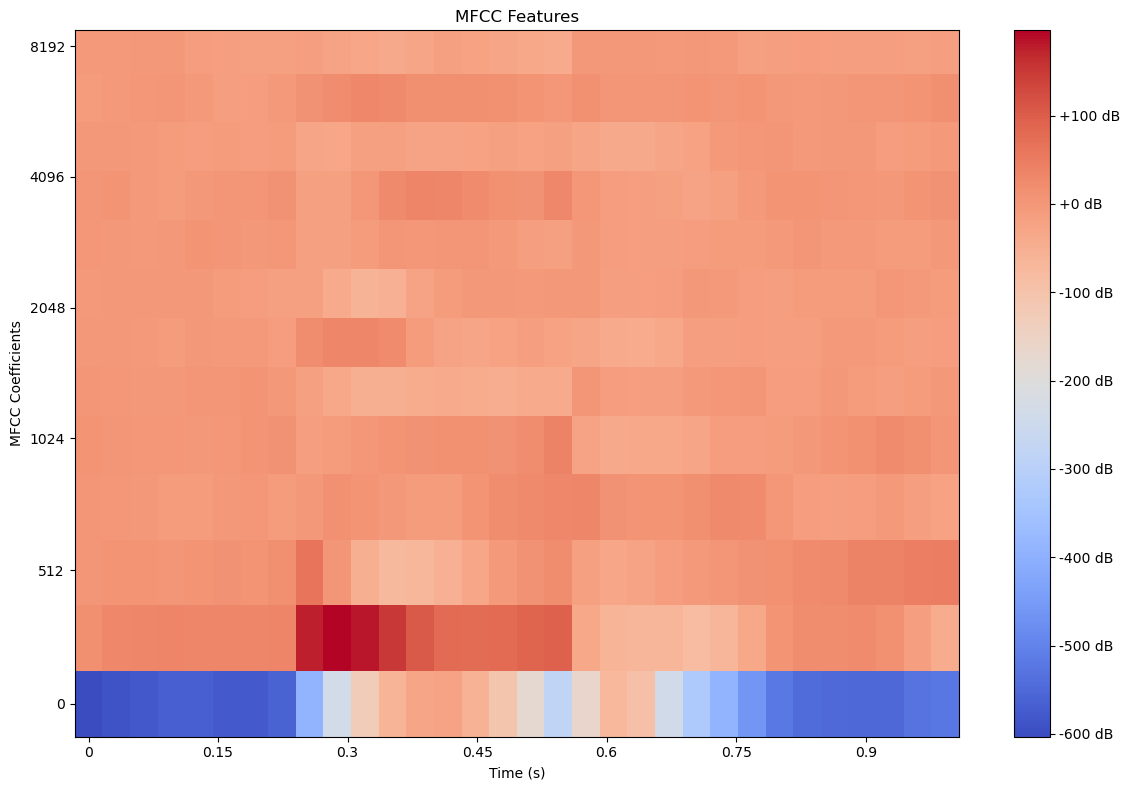

In [17]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
file_path = 'C:/Users/naikg/keyword-spotting/data/google_speech_recognition_v2/right/bb05582b_nohash_3.wav'  # Replace with your audio file path
audio, sr = librosa.load(file_path, sr=None)

# Compute MFCC features
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)

# Display MFCC features
plt.figure(figsize=(12, 8))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel', 
                         hop_length=512, cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC Features')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()


spitting the dataset

In [48]:
from sklearn.model_selection import train_test_split

def split_data(files, labels, test_size=0.1, val_size=0.1):
    # Split data into training and temp (for validation and test)
    X_train, X_temp, y_train, y_temp = train_test_split(files, labels, test_size=test_size + val_size, random_state=42)
    
    # Split temp data into validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
file_paths=[]
labels=[]
# Example usage



X_train, X_val, X_test, y_train, y_val, y_test = split_data(features_list, labels_list)

# Print the results
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Training set size: 8804
Validation set size: 1100
Test set size: 1101


saving the data set

In [16]:
import numpy as np

# Function to pad a 2D array (each sub-array)
def pad_array_2d(arr, target_shape):
    padded_arr = np.zeros(target_shape)  # Create an array filled with zeros
    arr = np.array(arr)
    # Copy the content of the original array into the padded array
    padded_arr[:arr.shape[0], :arr.shape[1]] = arr
    return padded_arr

# Find the maximum number of rows and columns
max_rows = max(len(sub_list) for sub_list in features_list)
max_cols = max(len(sub_sub_list) for sub_list in features_list for sub_sub_list in sub_list)

# Pad each sub-array to the maximum rows and columns
features_array = np.array([pad_array_2d(sub_list, (max_rows, max_cols)) for sub_list in features_list])
labels_array = np.array(labels_list)

# Save arrays to .npy files
np.save('train_features.npy', features_array)
np.save('train_labels.npy', labels_array)

print("Data padded and saved successfully.")


Data padded and saved successfully.


# mfcc feature 

In [20]:
import numpy as np

# Load the saved .npy files
features_array = np.load('train_features.npy', allow_pickle=True)
labels_array = np.load('train_labels.npy', allow_pickle=True)

print("Data loaded successfully.")

Data loaded successfully.


# lstm model

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [52]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))
# Display the model summary
model.summary()

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
from tensorflow.keras.utils import plot_model

# Save a visual representation of the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# If you want to display the plot directly (if you're in a Jupyter Notebook)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the saved image
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 128)               82432     
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 35)                2275      
                                                                 
Total params: 92963 (363.14 KB)
Trainable params: 92963 (363.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
35/35 [==============================] - 2s 12ms/step - loss: 3.6447 - accuracy: 0.0263
Test Loss: 3.6447086334228516, Test Accuracy: 0.026339691132307053
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/)

FileNotFoundError: [Errno 2] No such file or directory: 'model_plot.png'

# model with single lstm model with learning rate 0.001

In [24]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, 
          epochs=20,  # Increased number of epochs for better learning
          batch_size=64, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/20
138/138 [==============================] - 10s 42ms/step - loss: 4.0687 - accuracy: 0.0410 - val_loss: 3.7828 - val_accuracy: 0.0572 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 6s 41ms/step - loss: 3.6356 - accuracy: 0.0702 - val_loss: 3.5716 - val_accuracy: 0.0754 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 5s 37ms/step - loss: 3.4795 - accuracy: 0.0933 - val_loss: 3.4851 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 6s 41ms/step - loss: 3.3990 - accuracy: 0.1069 - val_loss: 3.4365 - val_accuracy: 0.0945 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 6s 41ms/step - loss: 3.3314 - accuracy: 0.1207 - val_loss: 3.3996 - val_accuracy: 0.0936 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 6s 42ms/step - loss: 3.2651 - accuracy: 0.1366 - val_loss: 3.3696 - val_accuracy: 0.1054 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 6s 41ms/s

FileNotFoundError: [Errno 2] No such file or directory: 'model_plot1.png'

In [25]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print(predicted_labels)

69/69 [==============================] - 1s 9ms/step - loss: 3.2727 - accuracy: 0.1527
Test Loss: 3.2727396488189697
Test Accuracy: 0.1526578813791275
69/69 [==============================] - 1s 8ms/step


NameError: name 'label_encoder' is not defined

In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model with custom learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)  # Set custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/20
138/138 [==============================] - 10s 42ms/step - loss: 4.0650 - accuracy: 0.0413 - val_loss: 3.7811 - val_accuracy: 0.0568 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 5s 33ms/step - loss: 3.6343 - accuracy: 0.0742 - val_loss: 3.5689 - val_accuracy: 0.0691 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 4s 31ms/step - loss: 3.4780 - accuracy: 0.0936 - val_loss: 3.4849 - val_accuracy: 0.0850 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 4s 31ms/step - loss: 3.4036 - accuracy: 0.0998 - val_loss: 3.4393 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 4s 31ms/step - loss: 3.3358 - accuracy: 0.1202 - val_loss: 3.4049 - val_accuracy: 0.0936 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 4s 31ms/step - loss: 3.2787 - accuracy: 0.1343 - val_loss: 3.3817 - val_accuracy: 0.0990 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 4s 30ms/s

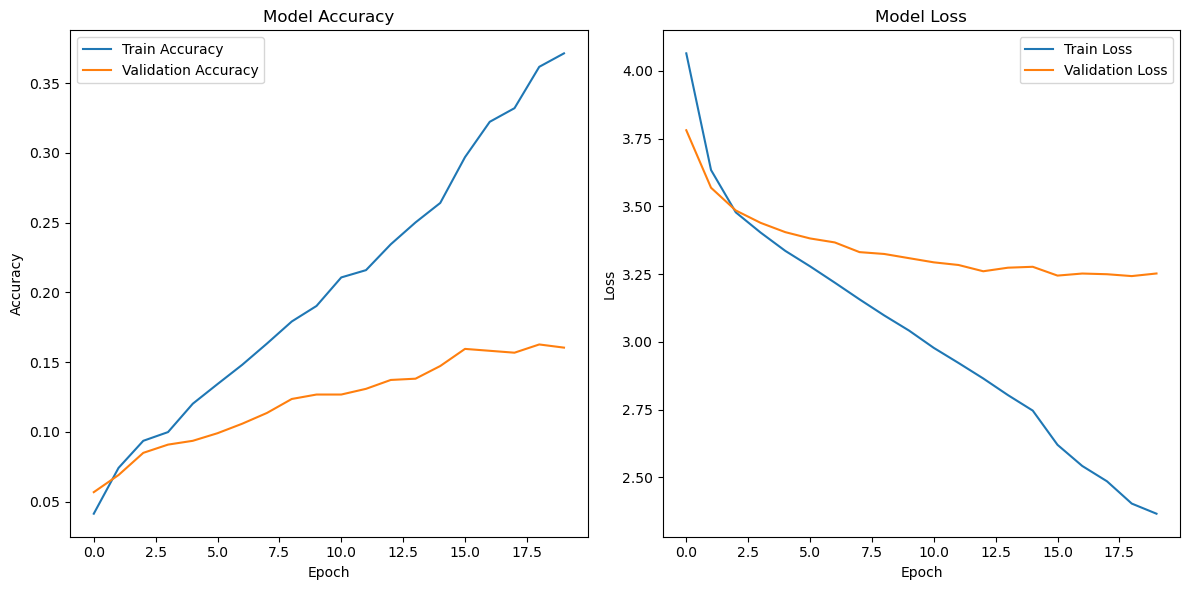

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# gru model
GRU (Gated Recurrent Unit)
GRUs are a simplified version of LSTMs. 
They have fewer gates and are computationally more efficient,
but often achieve similar performance in sequence modeling 

In [28]:
from tensorflow.keras.layers import GRU

# Define GRU Model
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



Epoch 1/10
138/138 [==============================] - 10s 40ms/step - loss: 4.2516 - accuracy: 0.0417 - val_loss: 3.9781 - val_accuracy: 0.0532
Epoch 2/10
138/138 [==============================] - 4s 27ms/step - loss: 3.8108 - accuracy: 0.0671 - val_loss: 3.7311 - val_accuracy: 0.0627
Epoch 3/10
138/138 [==============================] - 4s 27ms/step - loss: 3.5980 - accuracy: 0.0841 - val_loss: 3.5964 - val_accuracy: 0.0686
Epoch 4/10
138/138 [==============================] - 4s 27ms/step - loss: 3.4751 - accuracy: 0.0976 - val_loss: 3.5253 - val_accuracy: 0.0754
Epoch 5/10
138/138 [==============================] - 4s 27ms/step - loss: 3.3970 - accuracy: 0.1115 - val_loss: 3.4863 - val_accuracy: 0.0891
Epoch 6/10
138/138 [==============================] - 5s 34ms/step - loss: 3.3342 - accuracy: 0.1221 - val_loss: 3.4563 - val_accuracy: 0.0877
Epoch 7/10
138/138 [==============================] - 4s 32ms/step - loss: 3.2805 - accuracy: 0.1355 - val_loss: 3.4416 - val_accuracy: 0.096

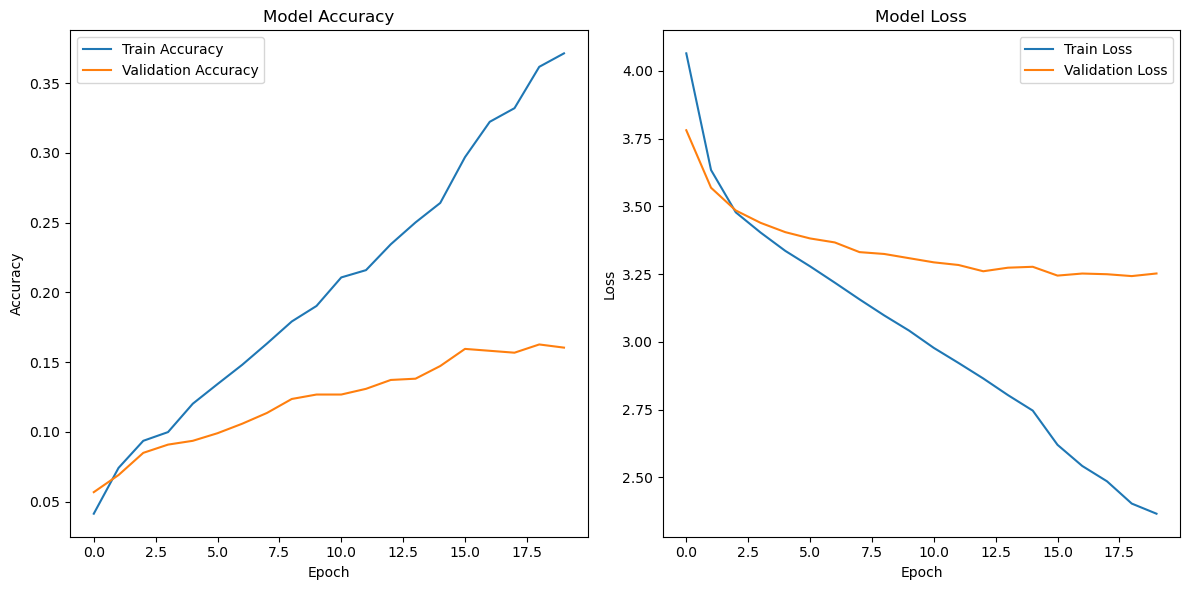

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model_plot.png'

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()
from tensorflow.keras.utils import plot_model

# Save a visual representation of the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# If you want to display the plot directly (if you're in a Jupyter Notebook)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the saved image
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()



# one layer bidirectional lstm model

In [30]:
from tensorflow.keras.layers import Bidirectional, LSTM

# Define Bidirectional LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/10
138/138 [==============================] - 14s 50ms/step - loss: 4.0864 - accuracy: 0.0520 - val_loss: 3.7071 - val_accuracy: 0.1022
Epoch 2/10
138/138 [==============================] - 6s 40ms/step - loss: 3.5129 - accuracy: 0.1161 - val_loss: 3.3506 - val_accuracy: 0.1472
Epoch 3/10
138/138 [==============================] - 6s 42ms/step - loss: 3.2524 - accuracy: 0.1512 - val_loss: 3.1876 - val_accuracy: 0.1786
Epoch 4/10
138/138 [==============================] - 5s 37ms/step - loss: 3.1119 - accuracy: 0.1783 - val_loss: 3.1016 - val_accuracy: 0.1767
Epoch 5/10
138/138 [==============================] - 5s 39ms/step - loss: 3.0032 - accuracy: 0.2048 - val_loss: 3.0473 - val_accuracy: 0.1945
Epoch 6/10
138/138 [==============================] - 5s 34ms/step - loss: 2.9116 - accuracy: 0.2266 - val_loss: 2.9995 - val_accuracy: 0.2131
Epoch 7/10
138/138 [==============================] - 5s 37ms/step - loss: 2.8380 - accuracy: 0.2468 - val_loss: 2.9741 - val_accuracy: 0.209

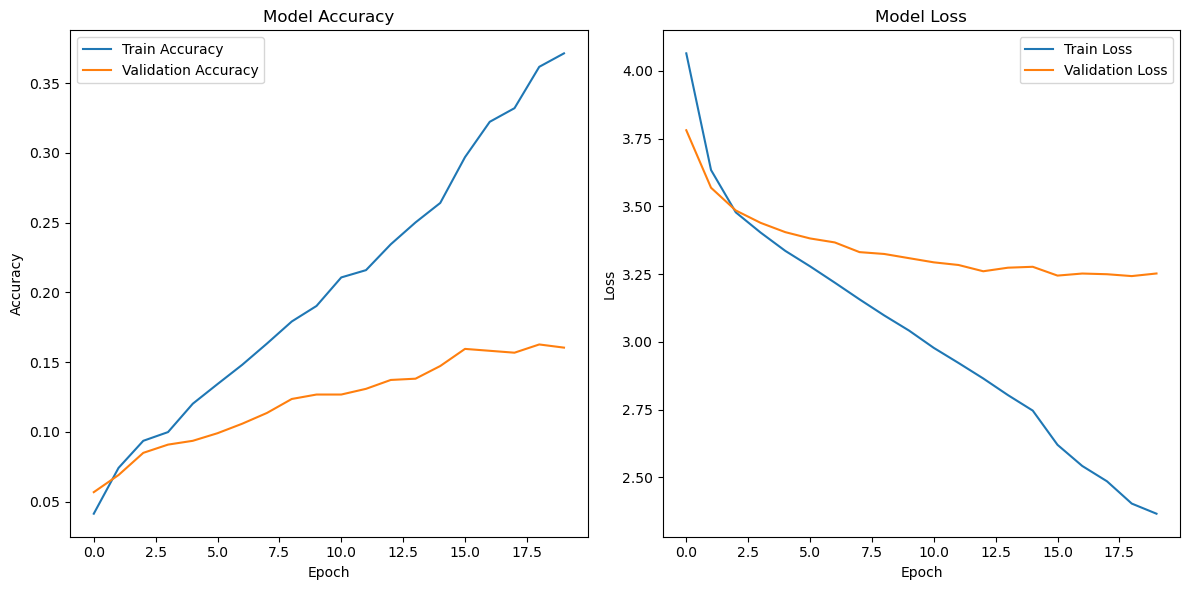

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# stack layed lstm

In [32]:
# Define Stacked LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



Epoch 1/10
138/138 [==============================] - 16s 62ms/step - loss: 3.8404 - accuracy: 0.0465 - val_loss: 3.6056 - val_accuracy: 0.0663
Epoch 2/10
138/138 [==============================] - 7s 49ms/step - loss: 3.4816 - accuracy: 0.0834 - val_loss: 3.3548 - val_accuracy: 0.0922
Epoch 3/10
138/138 [==============================] - 7s 49ms/step - loss: 3.2130 - accuracy: 0.1312 - val_loss: 3.0893 - val_accuracy: 0.1558
Epoch 4/10
138/138 [==============================] - 7s 48ms/step - loss: 3.0260 - accuracy: 0.1673 - val_loss: 2.9489 - val_accuracy: 0.1908
Epoch 5/10
138/138 [==============================] - 7s 49ms/step - loss: 2.8799 - accuracy: 0.2088 - val_loss: 2.8377 - val_accuracy: 0.2104
Epoch 6/10
138/138 [==============================] - 6s 43ms/step - loss: 2.7587 - accuracy: 0.2360 - val_loss: 2.7473 - val_accuracy: 0.2403
Epoch 7/10
138/138 [==============================] - 7s 48ms/step - loss: 2.6568 - accuracy: 0.2641 - val_loss: 2.6346 - val_accuracy: 0.268

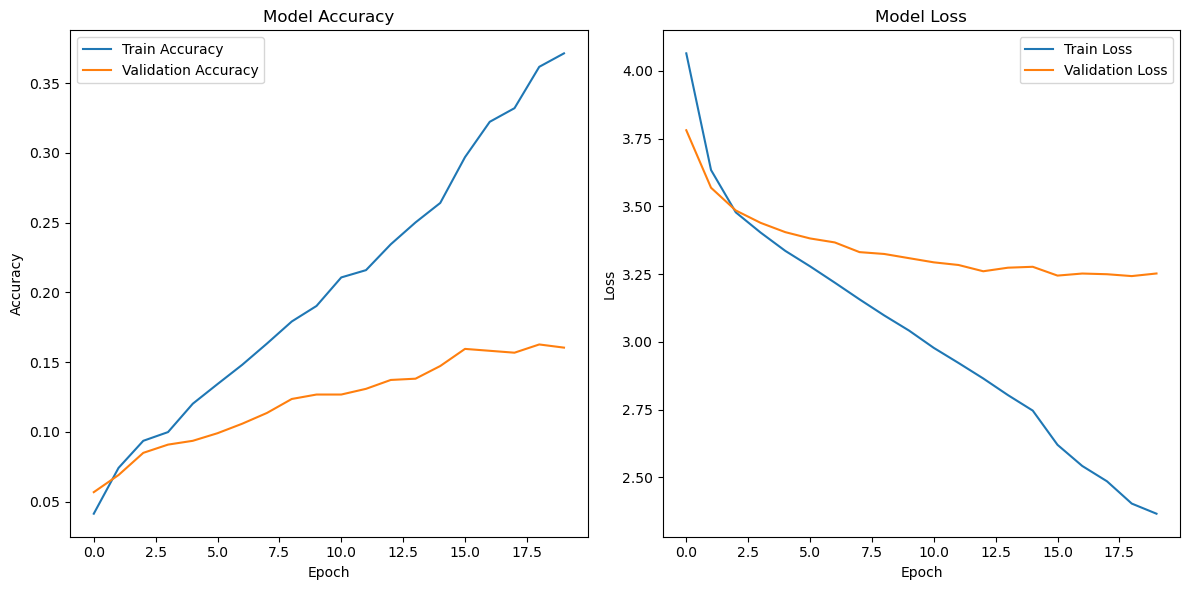

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# bidirectional gru model

In [34]:
# Define Bidirectional GRU Model
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/10
138/138 [==============================] - 14s 47ms/step - loss: 4.3440 - accuracy: 0.0559 - val_loss: 3.9587 - val_accuracy: 0.0841
Epoch 2/10
138/138 [==============================] - 4s 28ms/step - loss: 3.7012 - accuracy: 0.1128 - val_loss: 3.4731 - val_accuracy: 0.1349
Epoch 3/10
138/138 [==============================] - 5s 34ms/step - loss: 3.3311 - accuracy: 0.1554 - val_loss: 3.2471 - val_accuracy: 0.1658
Epoch 4/10
138/138 [==============================] - 5s 38ms/step - loss: 3.1337 - accuracy: 0.1934 - val_loss: 3.1155 - val_accuracy: 0.1981
Epoch 5/10
138/138 [==============================] - 5s 36ms/step - loss: 2.9927 - accuracy: 0.2188 - val_loss: 3.0454 - val_accuracy: 0.2158
Epoch 6/10
138/138 [==============================] - 5s 35ms/step - loss: 2.8993 - accuracy: 0.2423 - val_loss: 2.9951 - val_accuracy: 0.2167
Epoch 7/10
138/138 [==============================] - 5s 37ms/step - loss: 2.7997 - accuracy: 0.2698 - val_loss: 2.9671 - val_accuracy: 0.229

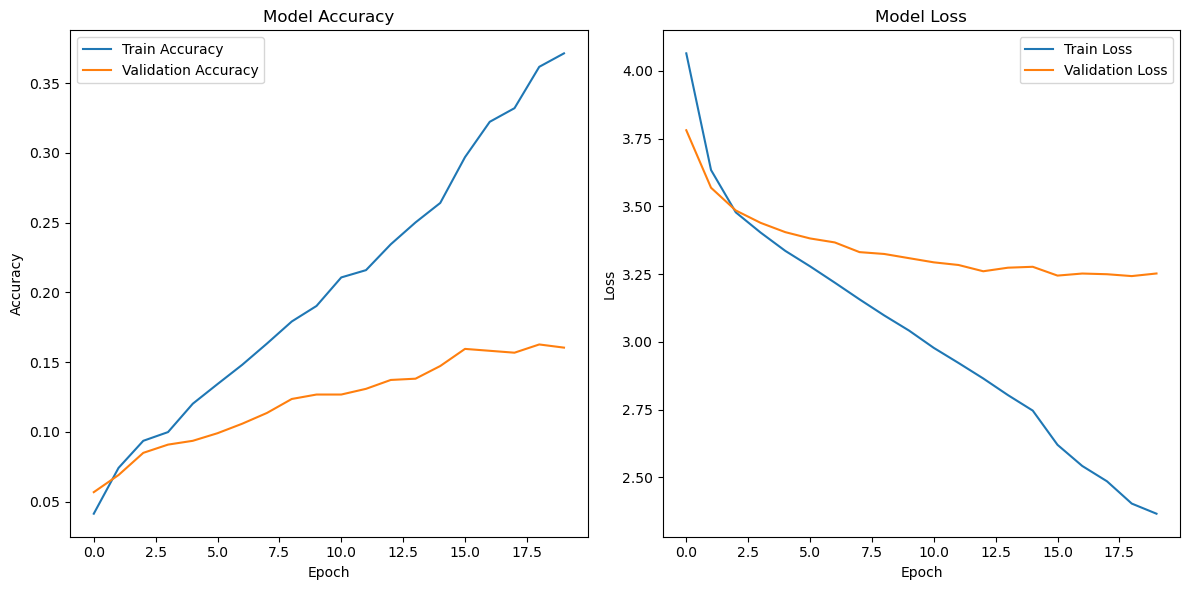

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# stack lstm 3 layer lstm

In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Stacked LSTM Model with 3 layers
model = Sequential()

# First LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Third LSTM layer with return_sequences=False (final LSTM layer)
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))  # Add dropout

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20,  # You can increase this if needed
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/20
138/138 [==============================] - 20s 70ms/step - loss: 3.7240 - accuracy: 0.0458 - val_loss: 3.5406 - val_accuracy: 0.0809 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 7s 52ms/step - loss: 3.4263 - accuracy: 0.0906 - val_loss: 3.2778 - val_accuracy: 0.1159 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 7s 51ms/step - loss: 3.2211 - accuracy: 0.1266 - val_loss: 3.1510 - val_accuracy: 0.1408 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 8s 58ms/step - loss: 3.0923 - accuracy: 0.1545 - val_loss: 3.0373 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 7s 54ms/step - loss: 2.9832 - accuracy: 0.1771 - val_loss: 2.9494 - val_accuracy: 0.1822 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 9s 63ms/step - loss: 2.9150 - accuracy: 0.1933 - val_loss: 2.8558 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 8s 58ms/s

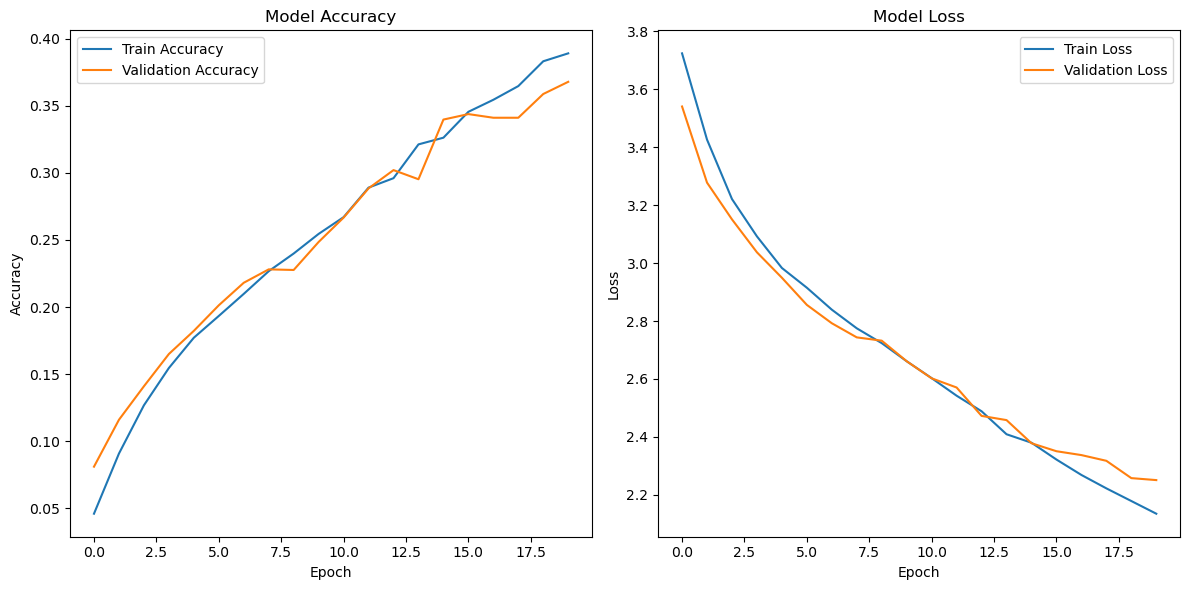

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# 5 layer lstm model adam optimizer initial learning rate 0.001

In [38]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Stacked LSTM Model with 5 layers
model = Sequential()

# First LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Third LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Fourth LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Fifth LSTM layer with return_sequences=False (final LSTM layer)
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))  # Add dropout

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



Epoch 1/20
138/138 [==============================] - 36s 141ms/step - loss: 3.6994 - accuracy: 0.0474 - val_loss: 3.4633 - val_accuracy: 0.0572 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 14s 102ms/step - loss: 3.3827 - accuracy: 0.0816 - val_loss: 3.2878 - val_accuracy: 0.1036 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 14s 101ms/step - loss: 3.2407 - accuracy: 0.1081 - val_loss: 3.2133 - val_accuracy: 0.1122 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 14s 102ms/step - loss: 3.1381 - accuracy: 0.1321 - val_loss: 3.0499 - val_accuracy: 0.1449 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 14s 99ms/step - loss: 3.0286 - accuracy: 0.1556 - val_loss: 2.9868 - val_accuracy: 0.1686 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 14s 103ms/step - loss: 2.9558 - accuracy: 0.1683 - val_loss: 2.8934 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 7/20
138/138 [==============================] -

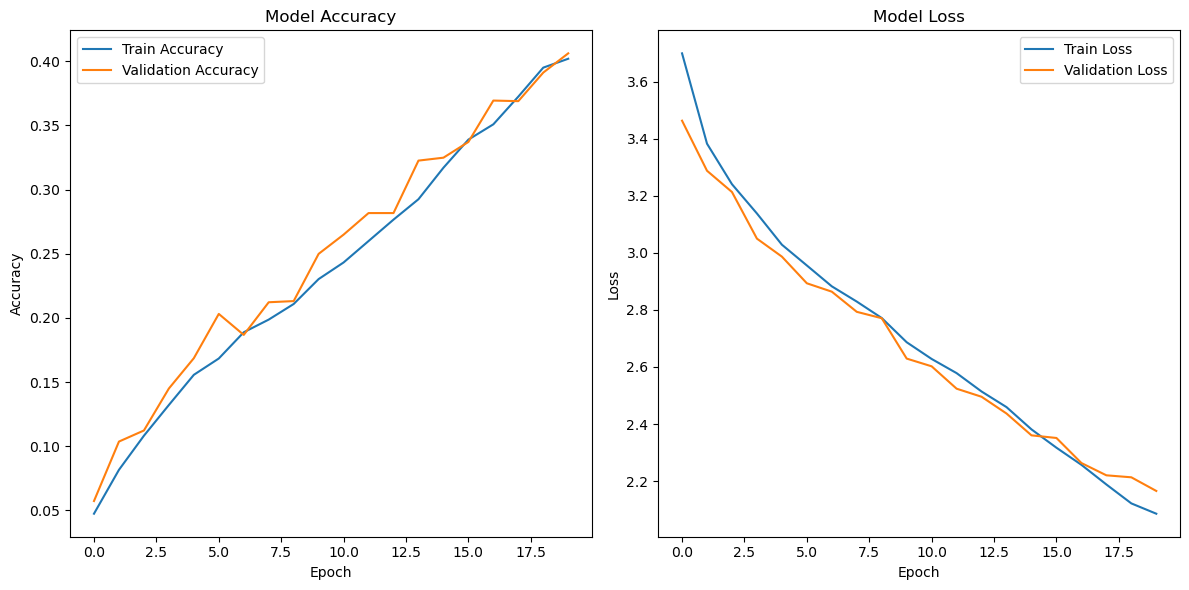

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# bidirectional and stack lstm model

Epoch 1/30
138/138 [==============================] - 46s 175ms/step - loss: 3.6838 - accuracy: 0.0532 - val_loss: 3.4473 - val_accuracy: 0.0632 - lr: 0.0010
Epoch 2/30
138/138 [==============================] - 19s 140ms/step - loss: 3.3544 - accuracy: 0.0906 - val_loss: 3.2756 - val_accuracy: 0.1100 - lr: 0.0010
Epoch 3/30
138/138 [==============================] - 19s 138ms/step - loss: 3.1839 - accuracy: 0.1260 - val_loss: 3.1062 - val_accuracy: 0.1418 - lr: 0.0010
Epoch 4/30
138/138 [==============================] - 19s 138ms/step - loss: 3.0317 - accuracy: 0.1505 - val_loss: 2.9454 - val_accuracy: 0.1763 - lr: 0.0010
Epoch 5/30
138/138 [==============================] - 18s 133ms/step - loss: 2.9074 - accuracy: 0.1871 - val_loss: 2.8643 - val_accuracy: 0.1904 - lr: 0.0010
Epoch 6/30
138/138 [==============================] - 19s 135ms/step - loss: 2.7854 - accuracy: 0.2192 - val_loss: 2.7760 - val_accuracy: 0.2281 - lr: 0.0010
Epoch 7/30
138/138 [==============================] 

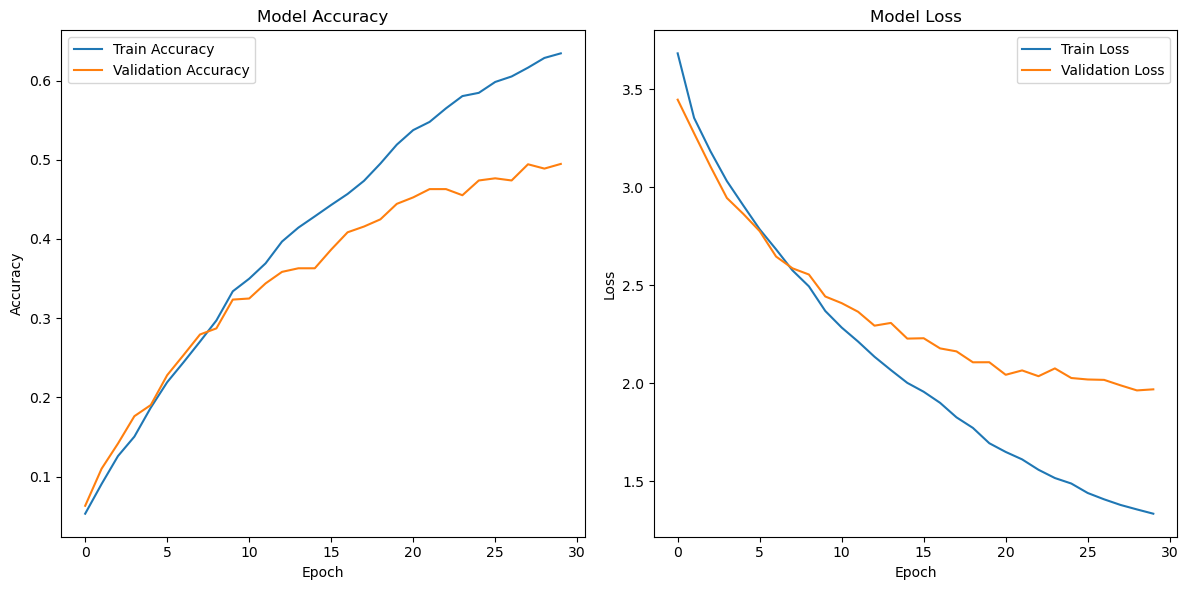

In [40]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Stacked LSTM Model with Bidirectional LSTMs
model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second LSTM layer (not bidirectional) with return_sequences=True
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

# Third Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

# Fourth LSTM layer (not bidirectional) with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))

# Fifth LSTM layer (not bidirectional) with return_sequences=False
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()




In [46]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Assuming X_train, y_train, X_test, and y_test are defined and preprocessed
# X_train shape: (num_samples, time_steps, num_features)
# y_train shape: (num_samples, num_classes)

# Define Stacked Bidirectional LSTM Model
model = Sequential()

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Dropout for regularization

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))  # Dropout for regularization

# Third Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128)))  # Last layer does not need return_sequences
model.add(Dropout(0.3))  # Dropout for regularization

# Fully connected layers
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

# Optional: Visualize training history (loss and accuracy)


Epoch 1/60
138/138 [==============================] - 49s 244ms/step - loss: 3.8299 - accuracy: 0.0714 - val_loss: 3.3321 - val_accuracy: 0.1172
Epoch 2/60
138/138 [==============================] - 31s 228ms/step - loss: 3.0845 - accuracy: 0.1715 - val_loss: 2.8470 - val_accuracy: 0.2208
Epoch 3/60
138/138 [==============================] - 31s 224ms/step - loss: 2.6979 - accuracy: 0.2612 - val_loss: 2.6456 - val_accuracy: 0.2658
Epoch 4/60
138/138 [==============================] - 30s 221ms/step - loss: 2.4161 - accuracy: 0.3336 - val_loss: 2.4044 - val_accuracy: 0.3471
Epoch 5/60
138/138 [==============================] - 31s 221ms/step - loss: 2.1806 - accuracy: 0.3950 - val_loss: 2.2274 - val_accuracy: 0.3948
Epoch 6/60
138/138 [==============================] - 31s 222ms/step - loss: 1.9743 - accuracy: 0.4625 - val_loss: 2.1158 - val_accuracy: 0.4230
Epoch 7/60
138/138 [==============================] - 29s 211ms/step - loss: 1.8045 - accuracy: 0.5035 - val_loss: 2.0735 - val_ac

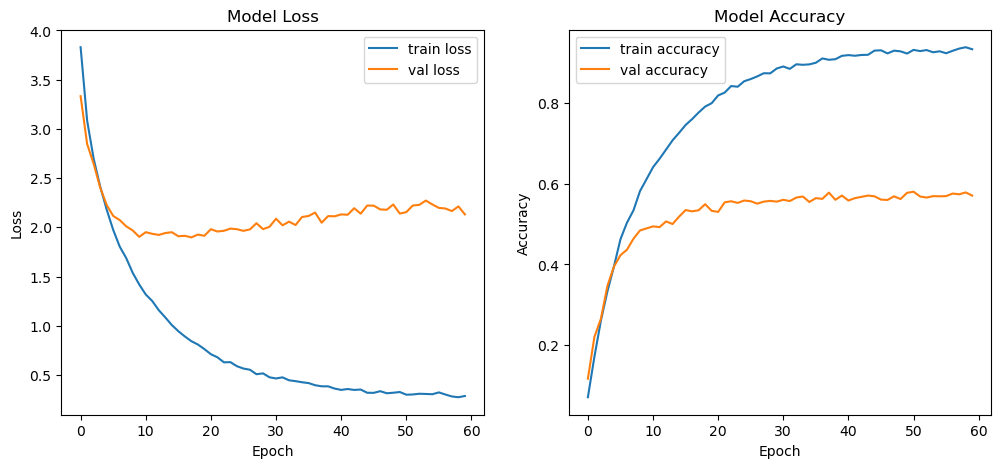

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 13, 256)           164864    
 ional)                                                          
                                                                 
 dropout_28 (Dropout)        (None, 13, 256)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 13, 256)           394240    
 ional)                                                          
                                                                 
 dropout_29 (Dropout)        (None, 13, 256)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                     

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# Display the model summary
model.summary()


from tensorflow.keras.utils import plot_model

# Save a visual representation of the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# If you want to display the plot directly (if you're in a Jupyter Notebook)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the saved image
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


In [53]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Assuming X_train, y_train, X_test, and y_test are defined and preprocessed
# X_train shape: (num_samples, time_steps, num_features)
# y_train shape: (num_samples, num_classes)

# Define Stacked Bidirectional LSTM Model
model = Sequential()

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Dropout for regularization

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))  # Dropout for regularization

# Third Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128)))  # Last layer does not need return_sequences
model.add(Dropout(0.3))  # Dropout for regularization

# Fully connected layers
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

# Optional: Visualize training history (loss and accuracy)


Epoch 1/60
155/155 [==============================] - 51s 223ms/step - loss: 3.7426 - accuracy: 0.0816 - val_loss: 3.1893 - val_accuracy: 0.1353
Epoch 2/60
155/155 [==============================] - 33s 216ms/step - loss: 2.9834 - accuracy: 0.1895 - val_loss: 2.7483 - val_accuracy: 0.2252
Epoch 3/60
155/155 [==============================] - 33s 212ms/step - loss: 2.5963 - accuracy: 0.2878 - val_loss: 2.5018 - val_accuracy: 0.3079
Epoch 4/60
155/155 [==============================] - 33s 214ms/step - loss: 2.3332 - accuracy: 0.3593 - val_loss: 2.3458 - val_accuracy: 0.3488
Epoch 5/60
155/155 [==============================] - 33s 216ms/step - loss: 2.1114 - accuracy: 0.4159 - val_loss: 2.1451 - val_accuracy: 0.3906
Epoch 6/60
155/155 [==============================] - 33s 210ms/step - loss: 1.9020 - accuracy: 0.4769 - val_loss: 2.0529 - val_accuracy: 0.4351
Epoch 7/60
155/155 [==============================] - 32s 209ms/step - loss: 1.7477 - accuracy: 0.5167 - val_loss: 1.9303 - val_ac

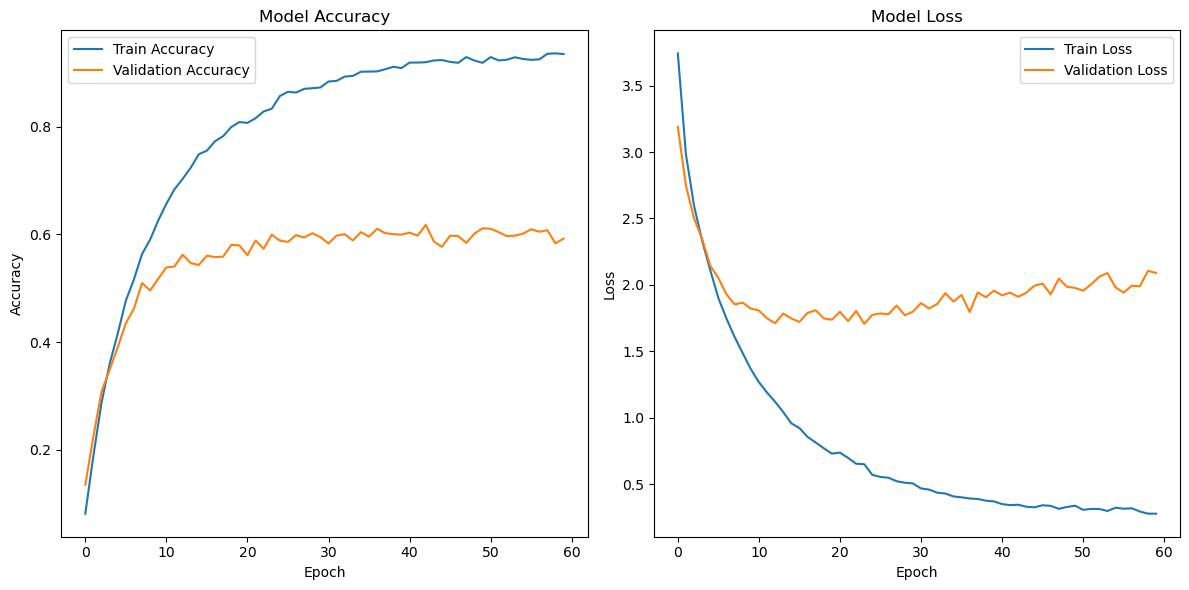

In [54]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


# hmm model

In [ ]:

from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import LabelEncoder

# Preprocess the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_array.flatten())  # Convert string labels to numeric form

# Reshape feature array for HMM - It expects 2D input (samples, features)
X_reshaped = features_array.reshape(-1, features_array.shape[2])  # Shape (11005 * 13, 32)

# Initialize Gaussian HMM
hmm_model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=100)

# Fit HMM to the data
hmm_model.fit(X_reshaped)

# Predict on the training data
hidden_states = hmm_model.predict(X_reshaped)
print("Hidden states predicted by HMM:", hidden_states)


hmm_model.summary()




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example of correct hidden_states array (replace with your actual array)
hidden_states = np.array([2, 3, 3, 0, 0, 0])  # Ensure no ellipsis here

# Plot the hidden states over time
plt.figure(figsize=(10, 6))
plt.plot(hidden_states, label="Predicted Hidden States", color="blue")
plt.title("Hidden State Sequence Predicted by HMM")
plt.xlabel("Time Step")
plt.ylabel("Hidden State")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these arrays already:
# Replace these with your actual arrays
hidden_states = np.array([2, 3, 3, 0, 0, 0])  # HMM predicted hidden states
y_true = np.array([2, 3, 2, 0, 0, 1])        # True labels

# Ensure they are of the same length
assert len(hidden_states) == len(y_true), "Lengths of predicted and true labels must match!"

# Plot the comparison
plt.figure(figsize=(10, 6))

# Plot the hidden states predicted by HMM
plt.plot(hidden_states, label="Predicted Hidden States", color="blue", marker='o')

# Plot the true labels
plt.plot(y_true, label="True Labels", color="red", linestyle='--', marker='x')

plt.title("Comparison of HMM Predicted Hidden States vs True Labels")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.legend()
plt.show()


# Convolutional Neural Networks (CNNs) for Time-Series

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Add more Conv1D layers or transition to Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=30,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    )
model.summary()
# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



#  CNN + LSTM hybrid model

In [45]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
# Define CNN + LSTM hybrid model
model = Sequential()

# CNN part
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM part
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                    epochs=60,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
model.summary()



Epoch 1/60
138/138 [==============================] - 8s 32ms/step - loss: 3.5342 - accuracy: 0.0401 - val_loss: 3.4537 - val_accuracy: 0.0700
Epoch 2/60
138/138 [==============================] - 3s 23ms/step - loss: 3.4620 - accuracy: 0.0555 - val_loss: 3.4031 - val_accuracy: 0.0727
Epoch 3/60
138/138 [==============================] - 4s 26ms/step - loss: 3.4266 - accuracy: 0.0660 - val_loss: 3.3609 - val_accuracy: 0.0813
Epoch 4/60
138/138 [==============================] - 3s 24ms/step - loss: 3.3878 - accuracy: 0.0755 - val_loss: 3.3216 - val_accuracy: 0.1050
Epoch 5/60
138/138 [==============================] - 3s 25ms/step - loss: 3.3564 - accuracy: 0.0836 - val_loss: 3.2933 - val_accuracy: 0.0963
Epoch 6/60
138/138 [==============================] - 4s 26ms/step - loss: 3.3262 - accuracy: 0.0920 - val_loss: 3.2469 - val_accuracy: 0.1081
Epoch 7/60
138/138 [==============================] - 3s 25ms/step - loss: 3.2991 - accuracy: 0.0998 - val_loss: 3.1970 - val_accuracy: 0.1168


KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# natural optimization model

# Particle Swarm Optimization (PSO) with PySwarms

In [10]:
def create_model():
    
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model


In [11]:
def get_number_of_params(model):
    return np.sum([np.prod(var.shape) for var in model.trainable_variables])


In [12]:
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])


In [13]:
def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.trainable_variables]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    weights = [flattened_weights[indices[i]:indices[i+1]].reshape(shape) for i, shape in enumerate(shapes)]
    return weights


In [14]:

def fitness_func(params):
    model = create_model()
    weights = unflatten_weights(params, model)
    model.set_weights(weights)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy  # PSO minimizes the objective function


In [39]:
pip install pyswarms


Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pyswarms as ps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam

# Define model architecture
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

# Flatten and unflatten functions
def flatten_weights(model):
    return np.concatenate([w.flatten() for w in model.get_weights()])

def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.get_weights()]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    weights = []
    for i, shape in enumerate(shapes):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        weight_shape = flattened_weights[start_idx:end_idx].shape
        print(f"Shape of flat weights slice for layer {i}: {weight_shape}, expected shape: {shape}")
        weights.append(flattened_weights[start_idx:end_idx].reshape(shape))
    return weights

# Define the fitness function
def fitness_func(params):
    model = create_model()
    weights = unflatten_weights(params, model)
    model.set_weights(weights)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy  # PSO minimizes the objective function

# Define PSO parameters
n_params = get_number_of_params(create_model())
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize and run PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)
cost, pos = optimizer.optimize(fitness_func, iters=10)


2024-09-15 15:18:23,881 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10

Shape of flat weights slice for layer 0: (10, 527011), expected shape: (32, 512)


ValueError: cannot reshape array of size 5270110 into shape (32,512)

In [18]:
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

def print_weights_info(model):
    weights = model.get_weights()
    for i, weight in enumerate(weights):
        print(f"Layer {i} weights shape: {weight.shape}")

model = create_model()
print_weights_info(model)


Layer 0 weights shape: (32, 512)
Layer 1 weights shape: (128, 512)
Layer 2 weights shape: (512,)
Layer 3 weights shape: (32, 512)
Layer 4 weights shape: (128, 512)
Layer 5 weights shape: (512,)
Layer 6 weights shape: (256, 512)
Layer 7 weights shape: (128, 512)
Layer 8 weights shape: (512,)
Layer 9 weights shape: (128, 256)
Layer 10 weights shape: (64, 256)
Layer 11 weights shape: (256,)
Layer 12 weights shape: (128, 256)
Layer 13 weights shape: (64, 256)
Layer 14 weights shape: (256,)
Layer 15 weights shape: (128, 256)
Layer 16 weights shape: (64, 256)
Layer 17 weights shape: (256,)
Layer 18 weights shape: (64, 128)
Layer 19 weights shape: (32, 128)
Layer 20 weights shape: (128,)
Layer 21 weights shape: (32, 64)
Layer 22 weights shape: (64,)
Layer 23 weights shape: (64, 35)
Layer 24 weights shape: (35,)


In [19]:
def get_number_of_params(model):
    return np.sum([np.prod(var.shape) for var in model.get_weights()])

n_params = get_number_of_params(create_model())
print("Total number of parameters:", n_params)


Total number of parameters: 527011


In [20]:
def flatten_weights(model):
    return np.concatenate([w.flatten() for w in model.get_weights()])


In [21]:
def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.get_weights()]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    
    weights = []
    for i, shape in enumerate(shapes):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        flattened_slice = flattened_weights[start_idx:end_idx]
        if np.prod(shape) != len(flattened_slice):
            raise ValueError(f"Shape mismatch: expected {np.prod(shape)}, got {len(flattened_slice)}")
        weights.append(flattened_slice.reshape(shape))
    
    return weights


In [22]:
def fitness_func(params):
    model = create_model()
    weights = unflatten_weights(params, model)
    model.set_weights(weights)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy  # PSO minimizes the objective function

# Check dimensions
n_params = get_number_of_params(create_model())
print("Number of parameters:", n_params)

# Initialize and run PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)
cost, pos = optimizer.optimize(fitness_func, iters=10)


Number of parameters: 527011


2024-09-15 15:20:04,060 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10


ValueError: Shape mismatch: expected 16384, got 10

In [23]:
def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.get_weights()]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    
    weights = []
    for i, shape in enumerate(shapes):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        flattened_slice = flattened_weights[start_idx:end_idx]
        print(f"Layer {i} shape: {shape}, flattened_slice shape: {flattened_slice.shape}")
        if np.prod(shape) != len(flattened_slice):
            raise ValueError(f"Shape mismatch: expected {np.prod(shape)}, got {len(flattened_slice)}")
        weights.append(flattened_slice.reshape(shape))
    
    return weights


In [24]:
def get_model_params(model):
    shapes = [w.shape for w in model.get_weights()]
    total_params = np.sum([np.prod(shape) for shape in shapes])
    return shapes, total_params

model = create_model()
shapes, total_params = get_model_params(model)
print("Model parameters shapes:", shapes)
print("Total number of parameters:", total_params)


Model parameters shapes: [(32, 512), (128, 512), (512,), (32, 512), (128, 512), (512,), (256, 512), (128, 512), (512,), (128, 256), (64, 256), (256,), (128, 256), (64, 256), (256,), (128, 256), (64, 256), (256,), (64, 128), (32, 128), (128,), (32, 64), (64,), (64, 35), (35,)]
Total number of parameters: 527011


In [25]:
def fitness_func(params):
    model = create_model()
    try:
        weights = unflatten_weights(params, model)
        model.set_weights(weights)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
        accuracy = history.history['val_accuracy'][-1]
        return -accuracy  # PSO minimizes the objective function
    except ValueError as e:
        print(f"ValueError in fitness function: {e}")
        return np.inf  # Return a high cost if there's an error


In [26]:
n_params = total_params  # Ensure this matches the number of parameters in your model
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)


In [27]:
import pyswarms as ps

# Example dimensions for PSO
n_params = total_params  # Ensure this matches the number of parameters in your model

# Initialize and run PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)
cost, pos = optimizer.optimize(fitness_func, iters=10)


2024-09-15 15:22:17,254 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10, best_cost=inf

Layer 0 shape: (32, 512), flattened_slice shape: (10, 527011)
ValueError in fitness function: Shape mismatch: expected 16384, got 10


ValueError: operands could not be broadcast together with shapes (0,) (10,527011) 

ValueError: cannot reshape array of size 3662464 into shape (784)

In [38]:
import numpy as np
from pyswarm import pso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess your data
# Assume feature_array and labels_array are already loaded
X = feature_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the function to optimize
def objective_function(params):
    # Unpack parameters
    units_layer1, units_layer2, learning_rate = int(params[0]), int(params[1]), params[2]
    
    # Build model
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(units_layer2, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return -accuracy  # We minimize the negative accuracy to maximize accuracy

# Define the bounds for each parameter
lb = [32, 32, 1e-5]  # lower bounds for [units_layer1, units_layer2, learning_rate]
ub = [128, 128, 1e-1]  # upper bounds for [units_layer1, units_layer2, learning_rate]

# Run PSO
best_params, best_score = pso(objective_function, lb, ub, swarmsize=20, maxiter=10, debug=True)

print("Best Parameters:", best_params)
print("Best Score (negative accuracy):", best_score)


ModuleNotFoundError: No module named 'pyswarm'

In [40]:
import numpy as np
import pyswarms as ps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,)

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



n_params = get_number_of_params(create_model())  # Total number of parameters
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)

# Run the PSO
cost, pos = optimizer.optimize(fitness_func, iters=10)



2024-09-15 15:34:59,681 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10, best_cost=inf

ValueError in fitness function: Shape mismatch: expected 212992, got 10


ValueError: operands could not be broadcast together with shapes (0,) (10,494115) 

In [41]:
pip install deap


     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB 991.0 kB/s eta 0:00:02
     -- ------------------------------------- 0.1/1.1 MB 787.7 kB/s eta 0:00:02
     ----- ---------------------------------- 0.1/1.1 MB 1.1 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.1 MB 984.6 kB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.1 MB 935.2 kB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.1 MB 860.2 kB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.1 MB 860.2 kB/s eta 0:00:01
     ----------- ---------------------------- 0.3/1.1 MB 764.6 kB/s eta 0:00:02
     ------------- -------------------------- 0.3/1.1 MB 800.8 kB/s eta 0:00:01
     -------------- ------------------------- 0.4/1.1 MB 786.0 kB/s eta 0:00:01
     ---------------- ----------------------- 0.4/1.1 MB 813.6 kB/s eta 0:00:01
     ---------------- ----------------------- 0.4/1

In [44]:
import numpy as np
import tensorflow as tf
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess your data
X = features_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function
def evaluate(individual):
    units_layer1, units_layer2, learning_rate = int(individual[0]), int(individual[1]), individual[2]

    # Build model
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(units_layer2, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return (accuracy,)

# Setup GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 32, 128)
toolbox.register("attr_float", np.random.uniform, 1e-5, 1e-1)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_int, toolbox.attr_float), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=10)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

# Get the best individual
best_individual = tools.selBest(population, 1)[0]
print("Best Parameters:", best_individual)


C:\Users\naikg\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\naikg\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


ValueError: in user code:

    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 35) and (None, 13, 35) are incompatible


In [45]:
pip install scikit-optimize


  Obtaining dependency information for scikit-optimize from https://files.pythonhosted.org/packages/65/cd/15c9ebea645cc9860aa71fe0474f4be981f10ed8e19e1fb0ef1027d4966e/scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pyaml>=16.9 from https://files.pythonhosted.org/packages/17/78/bafa787bd01ee6b4fc373793bda018f784e3ad457f5da6d787dbdcb902b8/pyaml-24.7.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/107.8 kB ? eta -:--:--
   -------------- ------------------------ 41.0/107.8 kB 393.8 kB/s eta 0:00:01
   ------------------------------------ - 102.4/107.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------------- 107.8/107.8 kB 621.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [50]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load and preprocess your data
X = features_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model-building function
def build_model(units_layer1, units_layer2, learning_rate):
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(units_layer2, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=0)

# Define search space
search_space = {
    'units_layer1': Integer(32, 128),
    'units_layer2': Integer(32, 128),
    'learning_rate': Real(1e-5, 1e-1, prior='log-uniform')
}

# Perform Bayesian Optimization
opt = BayesSearchCV(model, search_space, n_iter=10, cv=3, scoring='accuracy', verbose=0)
opt.fit(X_train, y_train)

print("Best Parameters:", opt.best_params_)


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [47]:
pip install simanneal


  Obtaining dependency information for simanneal from https://files.pythonhosted.org/packages/8b/cd/1b1f58a8e3fc041e352fb0ac2e4018f8f5be1f5fdde9996f157f0eb6d3cf/simanneal-0.5.0-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [60]:
from simanneal import Annealer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM

def build_model(units_layer1, units_layer2, learning_rate):
    model = Sequential([
        LSTM(units_layer1, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        LSTM(units_layer2),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# Load and preprocess your data
X = features_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# Flatten the input data if you don't need the extra dimension
X = X.reshape(X.shape[0], -1)  # Flatten to shape (11005, 13*32)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM

class NeuralNetworkAnnealer(Annealer):
    def __init__(self, X_train, y_train, X_test, y_test, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        print("Shape of X_train:", self.X_train.shape)


    def energy(self):
        units_layer1 = int(self.state[0])
        units_layer2 = int(self.state[1])
        learning_rate = self.state[2]
        
        # Ensure you use the correct input shape
        input_shape = (self.X_train.shape[1], self.X_train.shape[2]) if len(self.X_train.shape) == 3 else (self.X_train.shape[1],)
        
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(units_layer1, activation='relu'),
            Dense(units_layer2, activation='relu'),
            Dense(self.y_train.shape[1], activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = model.fit(self.X_train, self.y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        loss, accuracy = model.evaluate(self.X_test, self.y_test, verbose=0)
        return -accuracy  # Minimize negative accuracy (maximize accuracy)
    

# Example initial parameters
initial_state = [64, 32, 0.001]  # Adjust as necessary
annealer = NeuralNetworkAnnealer(X_train, y_train, X_test, y_test, initial_state=initial_state)

# Run annealing
state, energy = annealer.anneal()
print("Best Parameters:", state)
print("Best Score (negative accuracy):", energy)


Shape of X_train: (8804, 416)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best Parameters: [64, 32, 0.001]
Best Score (negative accuracy): -0.538391649723053
